# 前処理

In [0]:
#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
!pip install keras-rl

     |████████████████████████████████| 40kB 3.4MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp36-none-any.whl size=48379 sha256=554106120800c877ca3ca3a7deb6420251c517728924a0d0281449b4019d3147
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl


# QL Agent

In [0]:
import gym
import pickle
import os
import rl.core
import numpy as np
import matplotlib.pyplot as plt

class PendulumProcessor(rl.core.Processor):
    def __init__(self, split_num=8):
        # 各値の最小,最大値
        self.env_low = np.array([-1.0, -1.0, -8.0])
        self.env_high = np.array([1.0, 1.0, 8.0])

        # 分割の基準となる値
        self.env_dx = (self.env_high - self.env_low) / split_num
    
    def process_observation(self, observation):
        d = []
        for i, v in enumerate(observation):
            if v < self.env_low[i]:
                v  = self.env_low[i]
            elif v > self.env_high[i]:
                v = self.env_high[i]
            d.append(int(round((v - self.env_low[i]) / self.env_dx[i])))
        return d

    def process_action(self, action):
        ACT_ID_TO_VALUE = {
            0: [-2.0], 
            1: [-1.0], 
            2: [0.0], 
            3: [+1.0],
            4: [+2.0],
        }
        return ACT_ID_TO_VALUE[action]


class QLAgent(rl.core.Agent):
    def __init__(self, nb_actions, traning_rate=0.5, gamma=0.99, epsilon=0.1, **kwargs):
        super(QLAgent, self).__init__(**kwargs)
        self.compiled = False

        self.nb_actions = nb_actions

        self.q_table = {}
        self.q_table[""] = [np.random.uniform(low=-1, high=1) for _ in range(self.nb_actions)]

        self.traning_rate = traning_rate
        self.gamma = gamma

        self.epsilon = epsilon

    
    def reset_states(self):
        self.prev_observation  = ""
        self.prev_action = 0
        self.prev_reward = 0

    def compile(self, optimizer=None, metrics=[]):
        self.compiled = True
   
    def load_weights(self, filepath):
        with open(filepath, 'rb') as f:
            self.q_table = pickle.load(f)

    def save_weights(self, filepath, overwrite=False):
        if overwrite or not os.path.isfile(filepath):
            with open(filepath, 'wb') as f:
                pickle.dump(self.q_table, f)

    def forward(self, observation):
        # 文字列化して一意にする。
        observation = "_".join([str(o) for o in observation])
        
        # Qテーブルになければ追加(無限に増えます)
        if observation not in self.q_table:
            # Q値の初期化
            self.q_table[observation] = [ np.random.uniform(low=-1, high=1) for _ in range(self.nb_actions) ]
        
        
        if self.training:
            q_val = self.q_table[self.prev_observation][self.prev_action]  # Q(St,At)
            next_maxq = self.q_table[observation][np.argmax(self.q_table[observation])]  # MAX(Q(St+1,At))
            
            # 更新
            self.q_table[self.prev_observation][self.prev_action] = q_val + self.traning_rate * (self.prev_reward + self.gamma * next_maxq - q_val)
        
        if self.training:
            if self.epsilon > np.random.uniform(0, 1):
                # ランダム
                action = np.random.randint(0, self.nb_actions)
            else:
                # Q値が最大のindex(アクション)を取得
                action = np.argmax(self.q_table[observation])
            
        else:
            action = np.argmax(self.q_table[observation])
        
        self.prev_observation = observation
        self.prev_action = action
        return action

    def backward(self, reward, terminal):
        self.prev_reward = reward
        return []
    
    @property
    def layers(self):
        return []


Using TensorFlow backend.


# 学習

In [0]:
env = gym.make("Pendulum-v0")

nb_actions = 5  # PendulumProcessorで5個と定義しているので5

processor = PendulumProcessor(split_num=10)

# processorはAgentのコンストラクタの引数で渡します。
agent = QLAgent(nb_actions=nb_actions, traning_rate=0.4761866993824728, gamma=0.8901017844845089, epsilon=0.1, processor=processor)
agent.compile()

In [0]:
# 訓練
history = agent.fit(env, nb_steps=1_000_000, visualize=False, verbose=1)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 2s 159us/step - reward: -6.0298
50 episodes - episode_reward: -1205.966 [-1777.114, -752.250]

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 1s 147us/step - reward: -5.9707
50 episodes - episode_reward: -1194.143 [-1859.199, -753.380]

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 1s 142us/step - reward: -5.3793
50 episodes - episode_reward: -1075.854 [-1478.700, -506.328]

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 2s 170us/step - reward: -5.2149
50 episodes - episode_reward: -1042.986 [-1428.010, -504.470]

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 2s 154us/step - reward: -4.5702
50 episodes - episode_reward: -914.037 [-1338.329, -254.309]

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 1s 144u

# 結果

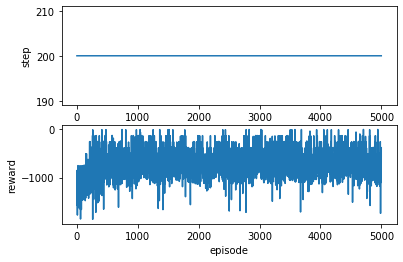

In [0]:
import matplotlib.pyplot as plt

# 結果を表示
plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")

plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")

plt.show()

In [0]:
import rl.callbacks
import matplotlib.pyplot as plt
import matplotlib.animation
import time
class ViewLogger(rl.callbacks.Callback):
    def __init__(self):
        self.frames = []

    # Callback から継承しています。
    def on_action_end(self, action, logs):
        self.frames.append(self.env.render(mode='rgb_array'))
    
    # 表示用
    def view(self, interval=5, start_frame=0, end_frame=0):
        assert start_frame<len(self.frames)
        if end_frame == 0:
          end_frame = len(self.frames)
        elif end_frame > len(self.frames):
            end_frame = len(self.frames)
        self.start_frame = start_frame
        self.t0 = time.time()
        
        # 表示サイズをここで指定しています。
        plt.figure(figsize=(2.5,2.5), dpi = 200)

        self.patch = plt.imshow(self.frames[0])
        plt.axis('off')
        
        ani = matplotlib.animation.FuncAnimation(plt.gcf(), self._plot, frames=end_frame - start_frame, interval=interval)
        return ani.to_jshtml()
      
    def _plot(self, frame):
        if frame % 200 == 0:
            print("{}f {}m".format(frame, (time.time()-self.t0)/60))
        self.patch.set_data(self.frames[frame + self.start_frame])

Testing for 5 episodes ...
Episode 1: reward: -746.580, steps: 200
Episode 2: reward: -621.360, steps: 200
Episode 3: reward: -863.059, steps: 200
Episode 4: reward: -888.029, steps: 200
Episode 5: reward: -497.194, steps: 200
0f 0.00030576388041178386m
0f 0.00035483837127685546m
200f 0.1613692283630371m
400f 0.3226199547449748m
600f 0.4840558727582296m
800f 0.6439140518506368m


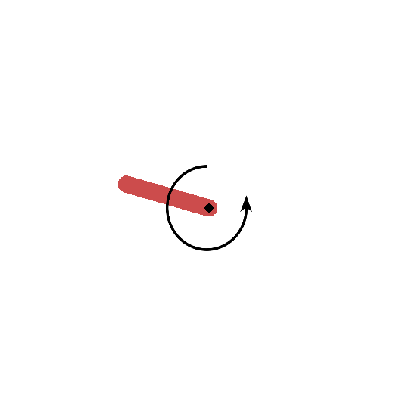

In [0]:
view = ViewLogger()
agent.test(env, nb_episodes=5, visualize=False, callbacks=[view])

from IPython.display import HTML
HTML(view.view(interval=10, start_frame=0, end_frame=0))